<a href="https://colab.research.google.com/github/vaibhavt147/Object-Classification-on-CIFER-10-Dataset/blob/master/CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Load necessary packages
import tensorflow as tf
from keras.datasets import cifar10
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
from keras.models import Sequential
from keras.layers import Dropout, Activation, Conv2D, GlobalAveragePooling2D
from keras.optimizers import SGD

In [2]:
# load the data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
print('Training Images: {}'.format(X_train.shape))
print('Testing Images: {}'.format(X_test.shape))
print(X_train[0].shape)

Training Images: (50000, 32, 32, 3)
Testing Images: (10000, 32, 32, 3)
(32, 32, 3)


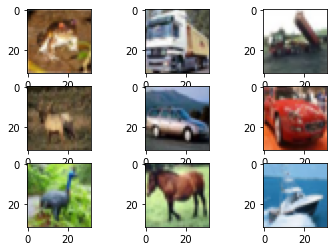

In [3]:
# create a grid of 3x3 images
for i in range(0,9):
    plt.subplot(330 + 1 + i)
    img = X_train[i].transpose([0,1,2])
    plt.imshow(img)
    
# show the plot
plt.show()

In [4]:
# Building a convolutional neural network for object recognition on CIFAR-10

# fix random seed for reproducibility
seed = 6
np.random.seed(seed) 

# load the data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# normalize the inputs from 0-255 to 0.0-1.0
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = X_train / 255.0
X_test = X_test / 255.0

# class labels shape
print(y_train.shape)
print(y_train[0])

(50000, 1)
[6]


In [5]:
# hot encode outputs
Y_train = np_utils.to_categorical(y_train)
Y_test = np_utils.to_categorical(y_test)
num_classes = Y_test.shape[1]

print(Y_train.shape)
print(Y_train[0])

(50000, 10)
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [6]:
# set up image augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
    #zoom_range=0.3
    )
datagen.fit(X_train)

In [7]:
device = tf.test.gpu_device_name()
if device != '/device:GPU:0' :
  raise SystemError('GPU device does not found')
print('GPU found at: {}'.format(device))

GPU found at: /device:GPU:0


In [8]:
# start building the model - import necessary layers

def allcnn(weights=None):
    # define model type - Sequential
    model = Sequential()

    # add model layers - Convolution2D, Activation, Dropout
    model.add(Conv2D(96, (3, 3), padding = 'same', input_shape=(32, 32, 3)))
    model.add(Activation('relu'))
    model.add(Conv2D(96, (3, 3), padding = 'same'))
    model.add(Activation('relu'))
    model.add(Conv2D(96, (3, 3), padding = 'same', strides = (2,2)))
    model.add(Dropout(0.5))

    model.add(Conv2D(192, (3, 3), padding = 'same'))
    model.add(Activation('relu'))
    model.add(Conv2D(192, (3, 3), padding = 'same'))
    model.add(Activation('relu'))
    model.add(Conv2D(192, (3, 3), padding = 'same', strides = (2,2)))
    model.add(Dropout(0.5))

    model.add(Conv2D(192, (3, 3), padding = 'same'))
    model.add(Activation('relu'))
    model.add(Conv2D(192, (1, 1), padding = 'valid'))
    model.add(Activation('relu'))
    model.add(Conv2D(10, (1, 1), padding = 'valid'))

    # add GlobalAveragePooling2D layer with Softmax activation
    model.add(GlobalAveragePooling2D())
    model.add(Activation('softmax'))
    
    # load the weights
    if weights:
        model.load_weights(weights)
    
    # return model
    return model

In [9]:
with tf.device('/device:GPU:0'):
  # define hyper parameters
  learning_rate = 0.01
  weight_decay = 1e-6
  momentum = 0.9

  #Load weights
  weights = '/content/drive/My Drive/Datasets/all_cnn_weights_0.9088_0.4994.hdf5'
  model = allcnn(weights)

  # define optimizer and compile model
  sgd = SGD(lr=learning_rate, decay=weight_decay, momentum=momentum, nesterov=True)
  model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

  # print model summary
  print (model.summary())

  # define additional training parameters
  epochs = 350
  batch_size = 32

  # fit the model
  model.fit(datagen.flow(X_train, Y_train, batch_size=batch_size), validation_data=(X_test, Y_test), epochs=epochs, verbose = 1)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 96)        2688      
_________________________________________________________________
activation (Activation)      (None, 32, 32, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 96)        83040     
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 96)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 96)        83040     
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 96)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 192)       1

In [10]:
  # make dictionary of class labels and names
classes = range(0,10)

names = ['airplane',
        'automobile',
        'bird',
        'cat',
        'deer',
        'dog',
        'frog',
        'horse',
        'ship',
        'truck']

# zip the names and classes to make a dictionary of class_labels
class_labels = dict(zip(classes, names))

# generate batch of 9 images to predict
batch = X_test[100:109]
labels = np.argmax(Y_test[100:109],axis=-1)

# make predictions
predictions = model.predict(batch, verbose = 1)

1/1 [==============================] - 0s 2ms/step


In [11]:
# these are individual class probabilities, should sum to 1.0 (100%)
for image in predictions:
    print(np.sum(image))

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


In [12]:
# use np.argmax() to convert class probabilities to class labels
class_result = np.argmax(predictions,axis=-1)
print (class_result)

[4 5 6 3 1 1 3 6 8]


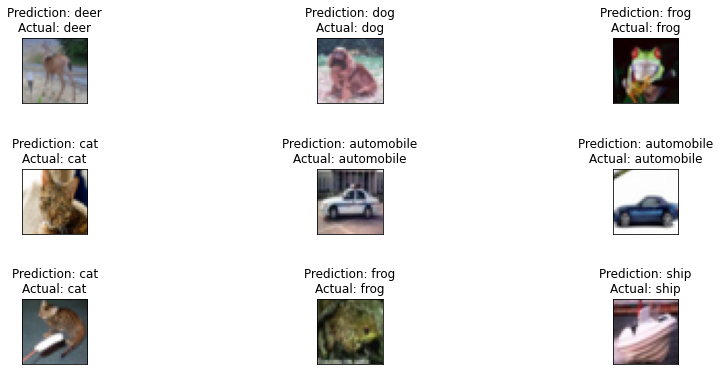

In [13]:
# create a grid of 3x3 images
fig, axs = plt.subplots(3, 3, figsize = (15, 6))
fig.subplots_adjust(hspace = 1)
axs = axs.flatten()

for i, img in enumerate(batch):

    # determine label for each prediction, set title
    for key, value in class_labels.items():
        if class_result[i] == key:
            title = 'Prediction: {}\nActual: {}'.format(class_labels[key], class_labels[labels[i]])
            axs[i].set_title(title)
            axs[i].axes.get_xaxis().set_visible(False)
            axs[i].axes.get_yaxis().set_visible(False)
            
    # plot the image
    axs[i].imshow(img.transpose([0,1,2]))
    
# show the plot
plt.show()